This example was adapted from skaae's Lasagne [recipe](https://github.com/skaae/Recipes/blob/spatial_transform/examples/spatial_transformer_network.ipynb).  
You can download skaae's Cluttered MNIST dataset [here](https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz).
This ipython notebook was adapted from Seya's spatial transformer network example
(https://github.com/EderSantana/seya/blob/keras1/examples/Spatial%20Transformer%20Networks.ipynb)

Reference at [arXiv](http://arxiv.org/abs/1506.02025)

In [1]:
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from scipy.misc import imresize
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Lambda, Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD

import keras.backend as K
from spatial_transformer_funtional_API import spatial_transformer

batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "../datasets/mnist_cluttered_60x60_6distortions.npz"

Using TensorFlow backend.


In [2]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], DIM, DIM, 1))
X_valid = X_valid.reshape((X_valid.shape[0], DIM, DIM, 1))
X_test = X_test.reshape((X_test.shape[0], DIM, DIM, 1))

y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))


input_shape =  np.squeeze(X_train.shape[1:])
input_shape = (60,60,1)
print("Input shape:",input_shape)

Train samples: (50000, 60, 60, 1)
Validation samples: (10000, 60, 60, 1)
Test samples: (10000, 60, 60, 1)
Input shape: (60, 60, 1)


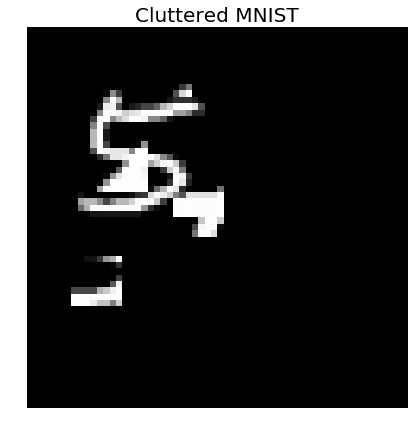

In [3]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [4]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [5]:
input_img = Input(shape=input_shape)

locnet = MaxPooling2D(pool_size=(2,2))(input_img)
locnet = Convolution2D(20, (5, 5))(locnet)
locnet = MaxPooling2D(pool_size=(2,2))(locnet)
locnet = Convolution2D(20, (5, 5))(locnet)

locnet = Flatten()(locnet)
locnet = Dense(50)(locnet)
locnet = Activation('relu')(locnet)
locnet = Dense(6, weights=weights)(locnet)
locnet = Activation('sigmoid')(locnet)

In [6]:
y = Lambda(lambda x: spatial_transformer(affine_transformation=x,
                                         input_shape=input_img,
                                         output_size=(30,30)),
           output_shape = (30,30,1))(locnet)
y = Convolution2D(32, (3, 3),padding='same')(y)
y = Activation('relu')(y)
y = MaxPooling2D(pool_size=(2,2))(y)
y = Convolution2D(32, (3, 3),padding='same')(y)
y = Activation('relu')(y)
y = MaxPooling2D(pool_size=(2,2))(y)
y = Flatten()(y)
y = Dense(256) (y)
y = Activation('relu')(y)
y = Dense(nb_classes) (y)
y = Activation('softmax')(y)
model = Model(input_img, y)
           
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 60, 1)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 20)        520       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 20)          10020     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1620)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                81050     
__________

In [8]:
XX = model.input
YY = model.layers[10].output
# <keras.layers.core.Lambda at 0x1cb35668278>
F = K.function([XX], [YY])

In [9]:
print(X_train.shape[0]/batch_size)

390.625


----------------------------------------
 9888/10000 [============================>.] - ETA: 0sEpoch: 0 | Valid: 0.9090991428375245 | Test: 0.9055514682769775


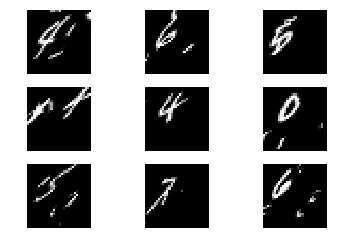

----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 1 | Valid: 0.556454001712799 | Test: 0.5505008589982986


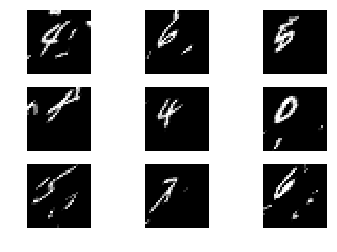

----------------------------------------
 9760/10000 [============================>.] - ETA: 0sEpoch: 2 | Valid: 0.470134637260437 | Test: 0.46438367908000944


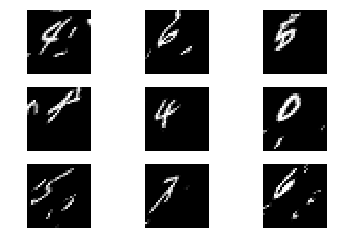

----------------------------------------
 9792/10000 [============================>.] - ETA: 0sEpoch: 3 | Valid: 0.4389092512369156 | Test: 0.4332453119277954


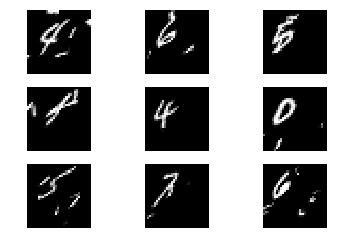

----------------------------------------
 9888/10000 [============================>.] - ETA: 0sEpoch: 4 | Valid: 0.37112334674596786 | Test: 0.3688323852062225


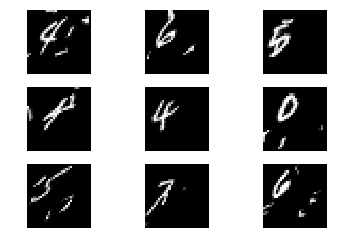

----------------------------------------
 9728/10000 [============================>.] - ETA: 0sEpoch: 5 | Valid: 0.35858571325540545 | Test: 0.35309607281684874


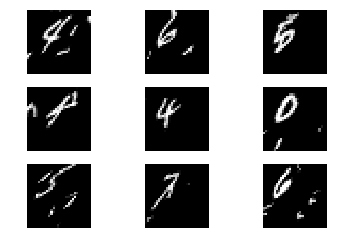

----------------------------------------
 9792/10000 [============================>.] - ETA: 0sEpoch: 6 | Valid: 0.32759588449001315 | Test: 0.3210092741072178


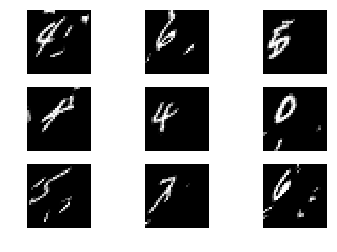

----------------------------------------
 9792/10000 [============================>.] - ETA: 0sEpoch: 7 | Valid: 0.3075036622226238 | Test: 0.2951297674238682


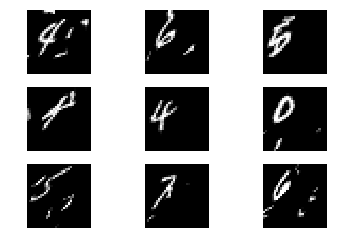

----------------------------------------
 9760/10000 [============================>.] - ETA: 0sEpoch: 8 | Valid: 0.26271444331407545 | Test: 0.2532370198071003


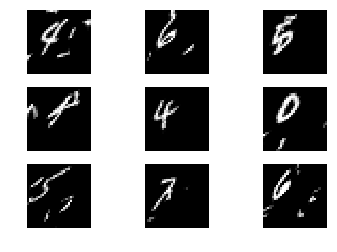

----------------------------------------
 9792/10000 [============================>.] - ETA: 0sEpoch: 9 | Valid: 0.24873665044903756 | Test: 0.24363648453503847


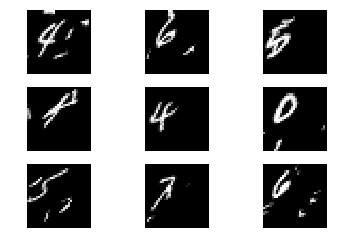

In [10]:
nb_epochs = 10 # you probably want to go longer than this
batch_size = 256
fig = plt.figure()
try:
    for e in range(nb_epochs):
        print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(150):
            #print(b)
            f = b * batch_size
            l = (b+1) * batch_size
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #print(loss)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scorev = model.evaluate(X_valid, y_valid, verbose=1)
        scoret = model.evaluate(X_test, y_test, verbose=1)
        print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))
        
        if e % 1 == 0:
            Xresult = F([X_batch[:9]])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                image = np.squeeze(Xresult[0][i])
                plt.imshow(image, cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
        
except KeyboardInterrupt:
    pass

### Visualizing what the Spatial Transformer learned

In [11]:
Xaug = X_train[:9]
Xresult = F([Xaug.astype('float32')])

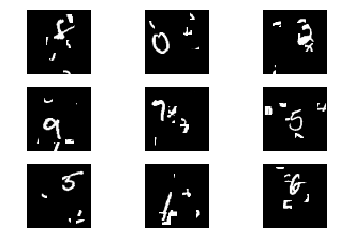

In [12]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

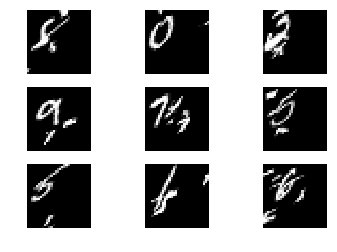

In [13]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')